Программа создаёт нейросеть, позволяющую по изображению определять тип одежды на картинке. У меня не было документации, как должна работать программа, поэтому я минимально исправил код и теперь в конце выводится совместный график обучения и валидации модели. Далее я сделал комментарии как работает программа и что я исправил.

Так как в Google Colab изначально не установлена torchviz, то скачиваем её.

In [1]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=d1de7cf73a37d05f08221c921b06143ab4efe25a84e840c4916afd3c2e505f0d
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


Импортируем все нужные библиотеки.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm import tqdm
from torchviz import make_dot
import matplotlib.pyplot as plt

Загружаем набор данных FashionMNIST и преобразуем изображения в тензоры.

In [3]:
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root = "./data", train = False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:10<00:00, 2532223.33it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 232452.46it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4290068.70it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4642502.04it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Подготовливаем пакеты данных (батчи) перед обучением модели.

In [4]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Извлекаем и анализируем первую порцию данных из обучающего и тестового наборов для понимания их структуры и формы.

In [5]:
train_item = next(iter(train_loader))
test_item = next(iter(test_loader))
len(train_item), len(test_item), train_item[0].shape, train_item[1].shape

(2, 2, torch.Size([64, 1, 28, 28]), torch.Size([64]))

Определяем класс нейронной сети NNModel, который наследуется от nn.Module из библиотеки PyTorch. Здесь нам необходимо убрать переопределение self.conv, оставив создание 2D-сверточного слой с ядром 1x1 и шагом 4.

In [6]:
class NNModel(nn.Module):
    def __init__(self,
                 layers_size = [49, 32, 16, 10],
                 dropout_prob = 1.0
                 ):
        super().__init__()
        self.conv = nn.Conv2d(1, 1, kernel_size = 1, stride = 4)
        # self.conv = nn.Conv2d(1, 1, kernel_size = 1, stride = 1)
        self.layers = [nn.Linear(layers_size[i], layers_size[i+1]) for i in range(len(layers_size)-1)]
        self.norm = [nn.BatchNorm1d(inp_size, affine  = False) for inp_size in layers_size[1:-1]]
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, batch):
        bs = batch.shape[0]
        batch = self.conv(batch).reshape(bs, -1)

        for i, layer in enumerate(self.layers):
            if i < len(self.layers) -1:
                batch = self.dropout(self.relu(self.norm[i](layer(batch))))
            else:
                batch = layer(batch)
        return batch

    def print_net(self):
        print(self.conv)
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) -1:
                print(layer)
                print(self.norm[i])
                print(self.relu)
                print(self.dropout)
            else:
                print(layer)

        return

Создаём модель, делающую предсказание для входного тензора, визуализируем архитектуру и выводим структуру сети в текстовом формате.

In [11]:
mlp  = NNModel(dropout_prob = 0.1)

predictions = mlp(train_item[0])
make_dot(predictions, params=dict(mlp.named_parameters()))
mlp.print_net()

Conv2d(1, 1, kernel_size=(1, 1), stride=(4, 4))
Linear(in_features=49, out_features=32, bias=True)
BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=32, out_features=16, bias=True)
BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=16, out_features=10, bias=True)


Процесса обучения и оценки модели.

Использование одного батча для обучения и оценки: Существует только один батч train_item, что необычно для реальной ситуации. Я заменил в оценке батч train_item на test_item.

Ошибки в оценочной части: В коде для оценки происходит обновление параметров, что неправильно. Нужно убрать вызовы loss.backward() и optimizer.step().

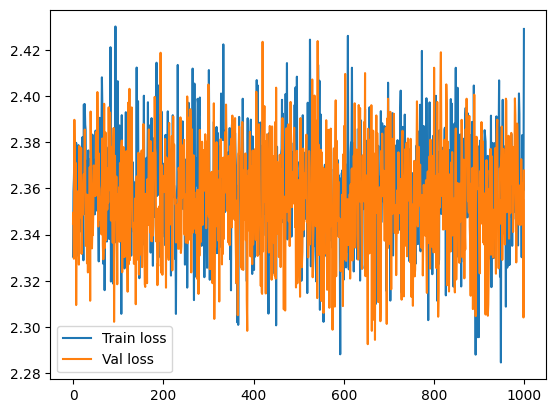

In [14]:
num_epochs = 1000
DEBUG = False
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr =  0.01)

logger = {'train':[],
          'eval' :[]
          }
for epoch in range(num_epochs):

    epoch_stat = []

    # train part
    mlp.train()
    for batch in [train_item]:

        images, labels = batch
        images, labels = images.float(), labels.long()
        predictions = mlp(images)
        loss = ce_loss(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_stat.append(loss.item())

    if DEBUG: print(f"train loss value = {np.mean(epoch_stat)}")
    logger['train'].append(np.mean(epoch_stat))


    # eval part
    with torch.no_grad():

        eval_stat = []
        for batch in [test_item]:

            images, labels = batch
            images, labels = images.float(), labels.long()
            predictions = mlp(images)
            loss = ce_loss(predictions, labels)
            # loss.backward()
            # optimizer.step()

            eval_stat.append(loss.item())
    if DEBUG: print(f"eval loss value = {np.mean(eval_stat)}")
    logger['eval'].append(np.mean(eval_stat))

plt.plot(logger['train'], label='Train loss' )
plt.plot(logger['eval'], label='Val loss')
plt.legend()
plt.show()

In [15]:
mlp

NNModel(
  (conv): Conv2d(1, 1, kernel_size=(1, 1), stride=(4, 4))
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [17]:
pytorch_total_params = sum(p.numel() for p in mlp.parameters())
pytorch_total_params

2